**Author:** Raoni Henriques da Silva

**Date:** 13/05/2021

This notebook is the conclusion project for the  course [Exploratory Data Analysis for Machine Learning](https://www.coursera.org/learn/ibm-exploratory-data-analysis-for-machine-learning) as part of the [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning).


# **Exploratory Data Analysis for Machine Learning**

**DATA PRE-PROCESSING REPORT**

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from scipy.stats import norm

sns.set()

## **1. INTRODUCING THE DATASET**

In [ ]:
path = 'https://raw.githubusercontent.com/Raoni-Silva/IBM_MachineLearning/main/01%20-%20Exploratory%20Data%20Analysis%20for%20Machine%20Learning/Data/titanic.csv'

data_raw = pd.read_csv(path)
data = data_raw.copy()

This is the dataset from the [Kaggle Titanic competion](https://www.kaggle.com/c/titanic/). 

Below is listed it's dictionary:

</br>

|**VARIABLE**|**DEFINITION**|**KEY**|**TYPE**|
|---|---|---|---|
|Passengerid|ID of the obervation||int|
|Survived|If the passenger survived (**target**)|0 = No, 1 = Yes|int|
|Pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|int|
|Name|Name of the passenger||string|
|Sex|Sex||string|
|Age|Age||float|
|SibSp|# of siblings / spouses aboard the Titanic||int|
|Parch|# of parents / children aboard the Titanic||int|
|Ticket|Ticket number||string|
|Fare|Passenger fare||float|
|Cabin|Cabin number||string|
|Embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|string|

In [ ]:
print(f'The dataset is composed of {data.shape[0]} rows and {data.shape[1]} features')

The dataset is composed of 891 rows and 12 features


## **2. DATA CLEANING**

Here we will be handling missing values and outliers.

### **Missing Values**

In [ ]:
null_list = []
null = data.isnull().sum()

for count, nulls in enumerate(null):
  if nulls > 0:
    null_list.append(null.index[count])
    print('{} = {:.2f}%'.format(null.index[count], nulls/len(data)*100))

Age = 19.87%
Cabin = 77.10%
Embarked = 0.22%


Here we can see the percentage of missing values from the features that have some.

* **Age**: The age missing values are going to be filled it with the median for each Title posteriorly in the Feature Engineering topic.
* **Cabin**: The Cabin has 77.10% of missing values. This is due to the fact that only the 1st class passengers have cabins, but the location of this cabin is important for the dataset, so here I will drop the missing values for the 1st class and define, later, an alternative value for the remaining missing values.
* **Embarked**: Since they are few examples, those missing values will have their row dropped.

In [ ]:
# # Filling the Age missing values with the median
# data['Age'].fillna(data_raw['Age'].median(), inplace=True)

# Finding the index from the data that will be droped.
index_1st_class = data[data['Pclass'] == 1 & data['Cabin'].isnull()].index

# Droping the first class Cabin and the Embarked missing value
data.drop(index_1st_class, inplace=True)
data.dropna(subset=['Embarked'], inplace = True)

# Filling the remaining Cabin missing values
data['Cabin'].fillna('Not_cabin', inplace=True)

### **Outliers**


In [ ]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,849.000000,849.000000,849.000000,686.000000,849.000000,849.000000,849.000000
mean,446.372203,0.378092,2.373380,29.202872,0.538280,0.398115,29.988226
std,257.903367,0.485197,0.802883,14.346565,1.122773,0.820892,45.976589
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.000000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,13.000000
75%,671.000000,1.000000,3.000000,37.750000,1.000000,0.000000,29.700000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The only feature that look like having outliers that maybe need some treatment is the `Fare`, but if it's necessary it will be handled posteriorly.

## **3. FEATURE ENGINEERING**

Before I go to the exploratory data analysis step I'll perform with some feature engineering to extract some underlying information from some features.

### **Titles**

The column name has not much use for a machine learning algorithm, but we can at least extract the title name. There are quite a few titles going around, but I want to reduce them all to Mrs. Miss, Mr and Master. To do this we'll need a function that searches substrings.

In [ ]:
data['Title'] = data['Name'].str.extract(' ([A-Z-a-z]+)\.', expand=False)

In [ ]:
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3,
                 'Dr': 3, 'Rev':3, 'Col':3}

In [ ]:
def replace_titles(x):
  title = x['Title']
  if title in ['Don', 'Major', 'Capt', 'Rev', 'Col']:
    return 'Mr'
  elif title in ['Countess', 'Mme']:
    return 'Mrs'
  elif title in ['Mlle', 'Ms']:
    return 'Miss'
  elif title in ['Lady', 'Sir']:
    return 'Master'
  elif title == 'Dr':
    if x['Sex'] == 'Male':
      return 'Mr'
    else:
      return 'Mrs'
  else:
    return title

data['Title'] = data.apply(replace_titles, axis=1)

In [ ]:
# Drop the name feature
data.drop('Name', axis=1, inplace=True)

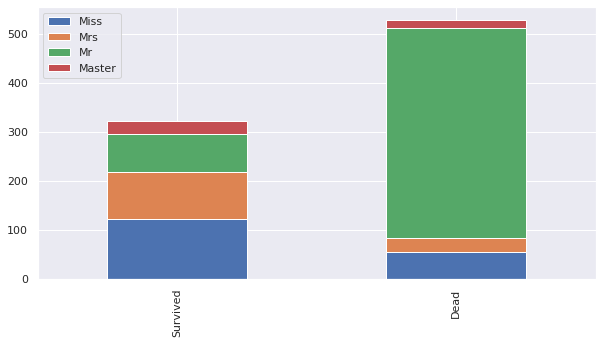

In [ ]:
bar_chart('Title')

### **Age**

Here we will fill the missing values with the median age per title and then apply binning to group ages per category.

**Feature vector map:**
* child: 0
* young: 1
* adult: 2
* mid-age: 3
* senior: 4

In [ ]:
# Filling the missing values with the median age per title
data['Age'].fillna(data.groupby('Title')['Age'].transform('median'), inplace=True)

In [ ]:
# Binning the age
data.loc[ data['Age'] <= 16, 'Age'] = 0
data.loc[ (data['Age'] > 16) & (data['Age'] <= 26), 'Age'] = 1
data.loc[ (data['Age'] > 26) & (data['Age'] <= 36), 'Age'] = 2
data.loc[ (data['Age'] > 36) & (data['Age'] <= 62), 'Age'] = 3
data.loc[ data['Age'] > 16, 'Age'] = 4

In [ ]:
def bar_chart(feature):
  survived = data[data['Survived']==1][feature].value_counts()
  dead = data[data['Survived']==0][feature].value_counts()
  df = pd.DataFrame([survived, dead])
  df.index = ['Survived', 'Dead']
  df.plot(kind='bar', stacked=True, figsize=(10,5))

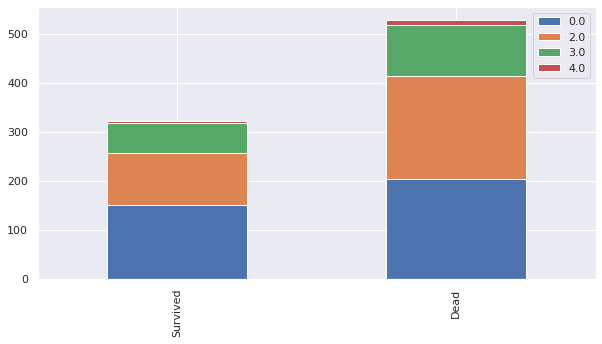

In [ ]:
bar_chart('Age')

### **Cabin Deck**
This is going be very similar, we have a `Cabin` column not doing much, only 1st class passengers have cabins, the rest are `Unknown`. A cabin number looks like `C123`. The letter refers to the deck, and so we’re going to extract these just like the titles.


In [ ]:
data['Cabin'] = data['Cabin'].str[:1]

### **Family Size**

Creating a new feature family size.

In [ ]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

### **Irrelevant variables for the model**

Here we will drop the `ticket`, `SibSp` and `Parch` features. The first one is not relevant to the model and the 2 others are already considered in the Family Size.

In [ ]:
features_drop = ['Ticket', 'SibSp', 'Parch']
data.drop(features_drop, axis=1, inplace=True)

## **4. EXPLORATORY DATA ANALYSIS (EDA)**



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 849 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  849 non-null    int64  
 1   Survived     849 non-null    int64  
 2   Pclass       849 non-null    int64  
 3   Sex          849 non-null    object 
 4   Age          849 non-null    float64
 5   Fare         849 non-null    float64
 6   Cabin        849 non-null    object 
 7   Embarked     849 non-null    object 
 8   Title        849 non-null    object 
 9   FamilySize   849 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 73.0+ KB


We have 10 attributes in total.
* 1 for ID 
* 1 target (Survived)
* 4 numerical 
* 4 categorical

We will do the EDA separately for each type of attribute.

### **EDA in Numeric Variables**

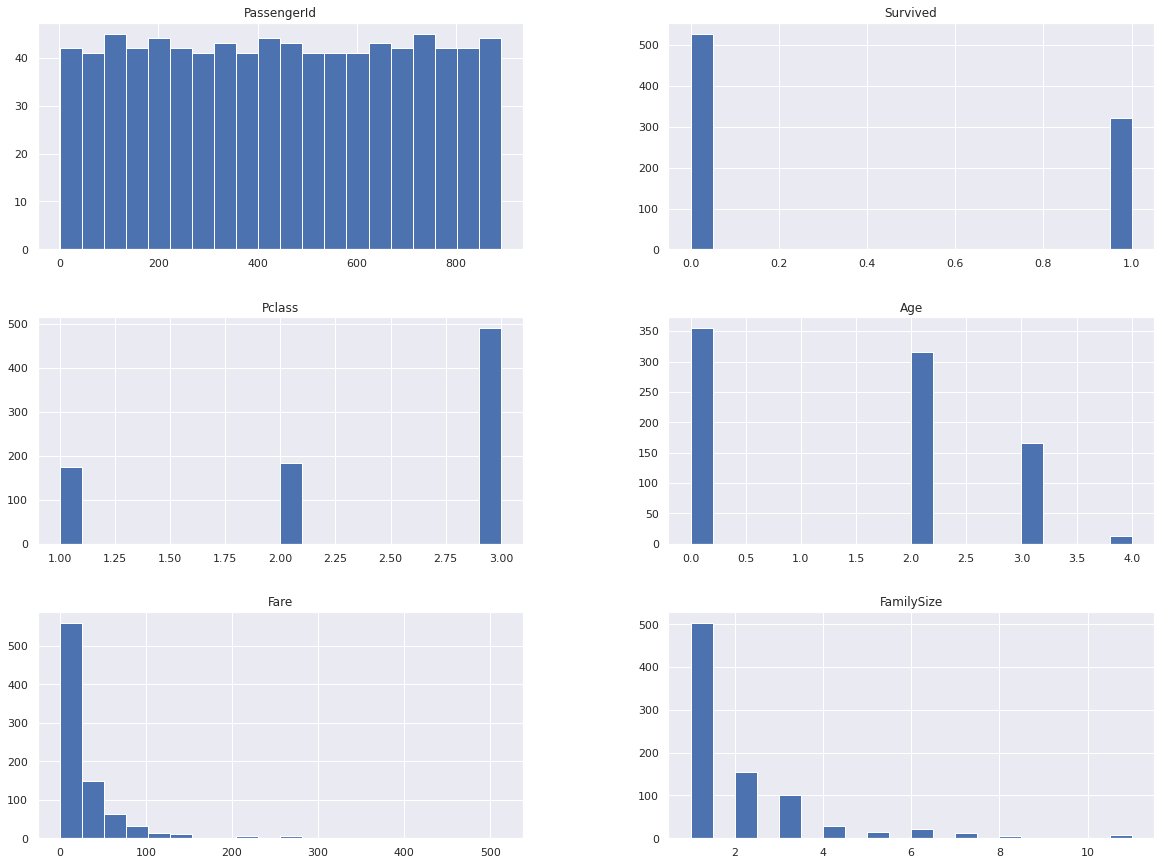

In [ ]:
data.hist(bins=20, figsize=(20,15));

In these previous plot we can see that the majority of the passanger are from the 3rd class.

### **EDA in Categorical Variables**

In [ ]:
data.describe(include=[object])  

,Sex,Cabin,Embarked,Title
count,849,849,849,849
unique,2,9,3,4
top,male,N,S,Mr
freq,550,647,623,505


### **Sex**

The male where more likely of dying.

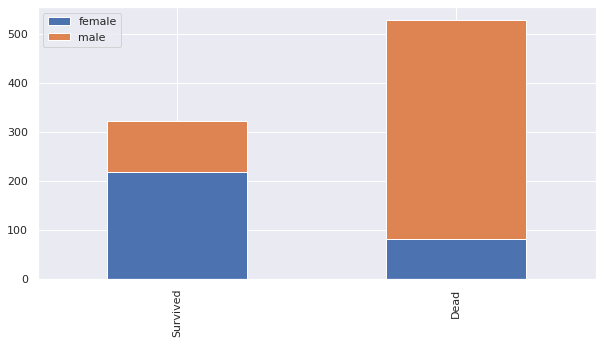

In [ ]:
bar_chart('Sex')

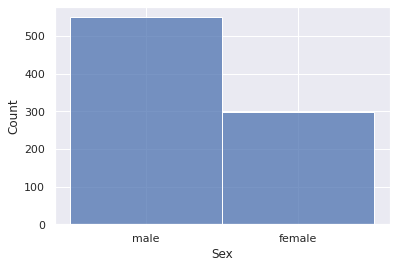

In [ ]:
sns.histplot(data['Sex']);

### **Cabin**

Most of the passengers where "Not Cabin".

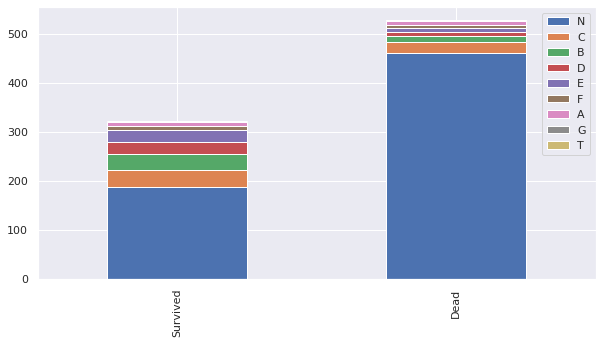

In [ ]:
bar_chart('Cabin')

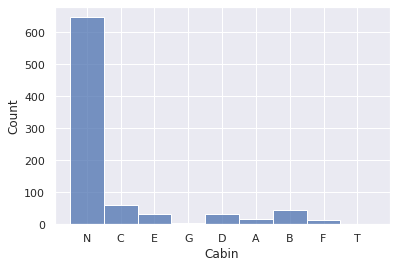

In [ ]:
sns.histplot(data['Cabin']);

### **Embarked**

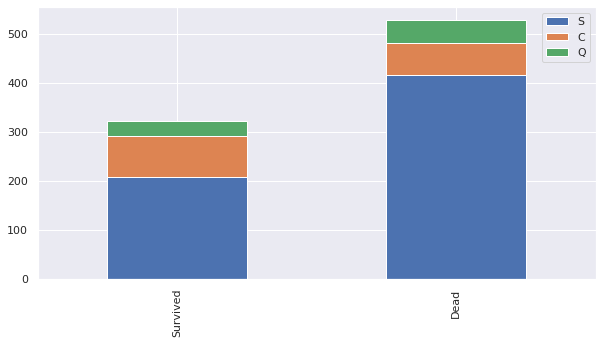

In [ ]:
bar_chart('Embarked')

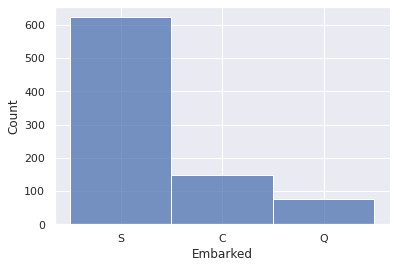

In [ ]:
sns.histplot(data['Embarked']);

### **Title**

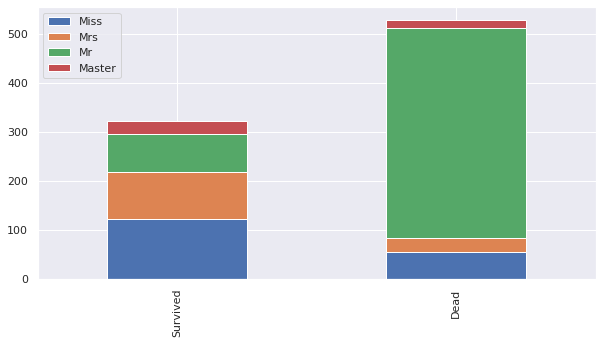

In [ ]:
bar_chart('Title')

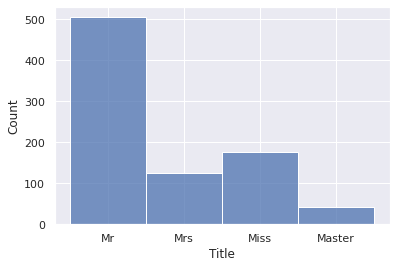

In [ ]:
sns.histplot(data['Title']);

We can see, like in the Sex topic, that the male had a bigger chance of dying then female.

## **5. FEATURE ENGINEERING RECAP**

Here we will transform the categorical variables into dummy variables.

### **Dummy Variables**

In [ ]:
data_eng = pd.get_dummies(data, drop_first=True)

In [ ]:
data_eng.head()

,PassengerId,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs
0,1,0,3,0.0,7.2500,2,1,0,0,0,0,0,0,1,0,0,1,0,1,0
1,2,1,1,3.0,71.2833,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,3,1,3,0.0,7.9250,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0
3,4,1,1,2.0,53.1000,2,0,0,1,0,0,0,0,0,0,0,1,0,0,1
4,5,0,3,2.0,8.0500,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0


## **6. HYPOTHESIS TESTING**

* **Hypothesis 01:** Being male increases the chances of the passenger dying.

$H_{0}$: If the passenger is male it is more likely that he will die.

$H_{A}$: There is no difference in the survival rate according to the sex of the passenger. 

* **Hypothesis 02:** Since some cabins where placed in the front of the ship, that has sinked first, the location of the cabin impact on the survival rate.

$H_{0}$: If the cabin is placed in the front of the ship it is more likely that he will die.

$H_{A}$: There is no difference in the survival rate according to the cabin of the passenger. 

* **Hypothesis 03:** We've all seen the Titanic movie and we saw the part when rich people started to give money to get priority on the safety boats. We can then make the hypothesis that rich people on the Titanic had a higher survival rate than the others.

For that we are interested in 3 features only:

**Survived:** a category of 0 and 1 which indicates whether that individual survived or not.

**Pclass:** The ship was divided into three classes. First, Second and Third.

**Fare:** The price that the passenger paid for the ticket.

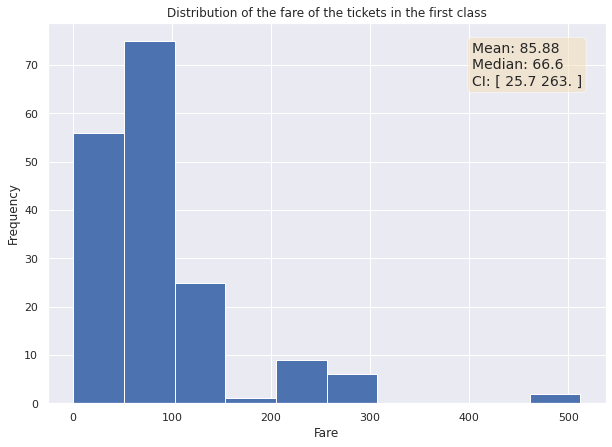

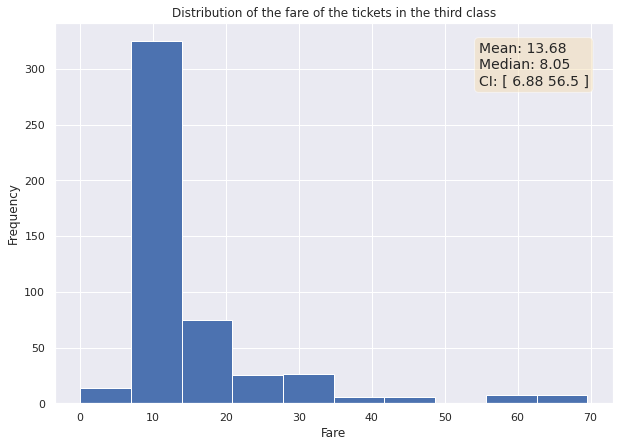

In [ ]:
# Distribution for rich:
first_fares = data["Fare"][data["Pclass"]==1]
first_mean = round(np.mean(first_fares), 2)
first_median = round(np.median(first_fares), 2)
first_conf = np.round(np.percentile(first_fares, [2.5, 97.5]), 2)

fig, ax = plt.subplots(figsize = (10, 7))

ax.hist(first_fares)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.76, 0.95, f"Mean: {first_mean} \nMedian: {first_median} \nCI: {first_conf}", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.title("Distribution of the fare of the tickets in the first class")
plt.show()

# Distribution for Poor
third_fares = data["Fare"][data["Pclass"]==3]
third_mean = round(np.mean(third_fares), 2)
third_median = round(np.median(third_fares), 2)
third_conf = np.round(np.percentile(third_fares, [2.5, 97.5]), 2)

fig, ax = plt.subplots(figsize = (10, 7))

ax.hist(third_fares)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.76, 0.95, f"Mean: {third_mean} \nMedian: {third_median} \nCI: {third_conf}", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.title("Distribution of the fare of the tickets in the third class")
plt.show()

The first-class tickets range from $25.70 to \$263.00 with an average of \$85.88 while the third class tickets range between \$6.88 and \$56.50 with an average of \$13.68. There is a clear representation of the socio-economic status of the people in the ship. so we can assume that those in the first-class group, as expected, are the rich.

### **Null and Alternative Hypothesis**

* $H_{0}$: The socio-economic class of the people didn't have an effect on the survival rate.
* $H_{A}$: The socio-economic class of the people affected their survival rate.

Taking a sample of 100 means from each population (first-class and third-class), using the central limit theorem, to ensure that our data is normally distributed.

In [ ]:
first_class_sample = np.array([np.mean(data[data["Pclass"]==1].sample(20)["Survived"].values) for i in range(100)])
third_class_sample = np.array([np.mean(data[data["Pclass"]==3].sample(20)["Survived"].values) for i in range(100)])

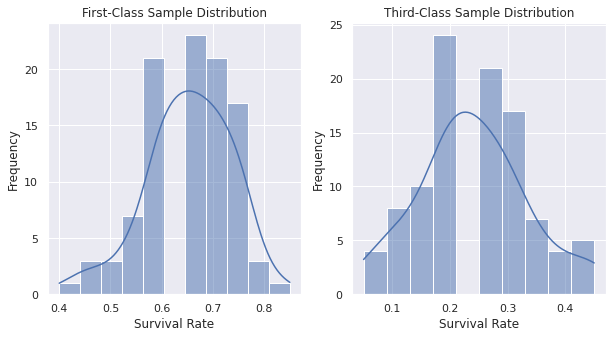

In [ ]:
plt.subplots(1, 2, figsize = (10, 5))
plt.subplot(1,2, 1)
sns.histplot(first_class_sample, kde=True)
plt.title("First-Class Sample Distribution")
plt.xlabel("Survival Rate")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(third_class_sample, kde=True)
plt.title("Third-Class Sample Distribution")
plt.xlabel("Survival Rate")
plt.ylabel("Frequency")
plt.show()

In [ ]:
effect = np.mean(first_class_sample) - np.mean(third_class_sample)
sigma_first = np.std(first_class_sample)
sigma_third = np.std(third_class_sample)
sigma_difference = np.sqrt((sigma_first**2)/len(first_class_sample)  +  (sigma_third**2)/len(third_class_sample))
z_score = effect / sigma_difference

In [ ]:
z_score

32.803979682844755

In [ ]:
p_value = norm.sf(abs(z_score))*2
p_value

5.1668959217520175e-236

### **Conclusion**

Since the `p_value` is so small we can **reject the null hypothesis**. The provided sample proves a significant correlation between the socio-economic class and the survival rate. We cannot establish causation between these two features but we can make a generalized induction that richer people had a better chance of survival at the ship.

## **REFERENCE**



* [Dataset](https://www.kaggle.com/c/titanic/overview)